In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc

/home/biostacs/anaconda2/envs/cnmf_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


# 1. prepare Input

这里将tsv格式转换为npz格式，加快文件读写效率

In [2]:
from timeit import default_timer as timer

tsv格式的基因表达矩阵的读取速度

In [3]:
filename = "../input/GSE154989_mmLungPlate_fQC_dSp_normTPM.tsv"
tic = timer()
tpm = pd.read_csv(filename, sep='\t', index_col=0)
toc = timer()
print(toc - tic) # unit: seconds

111.8370064329356


In [4]:
tpm.head()

,Gnai3,Cdc45,H19,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,Tbx2,...,AC121801.1,AC238940.3,Lats2.1,AC174797.6,AC125223.3,AC238811.4,AC161884.2,AC130217.2,KRASG12D,tdTomato
KP_30w_ND_m3_T7_P1_S302,0.00,0.0,0.0,0.0,0.00,7.57,7.33,0.00,7.22,0.0,...,0.0,0.74,0.0,0.0,0.0,0.0,0.0,0.0,0.00,10.75
KP_30w_ND_m2_T4_P5_S331,6.55,0.0,0.0,0.0,6.11,5.82,4.59,0.00,6.47,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,11.64
K_12w_ND_m3_T0_P2_S272,6.30,0.0,0.0,0.0,0.00,4.25,2.15,7.50,7.33,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,11.72
KP_30w_ND_m2_T1_P4_S219,4.92,0.0,0.0,0.0,4.23,5.33,5.74,5.40,7.34,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,4.43,11.48
K_2w_ND_m3_T0_P1_S245,5.44,0.0,0.0,0.0,0.00,5.93,5.86,5.07,5.33,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,9.97


In [5]:
def save_df_to_npz(obj, filename):
    np.savez_compressed(filename, data=obj.values, index=obj.index.values, columns=obj.columns.values)
    
def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

In [6]:
filename = "../input/GSE154989_mmLungPlate_fQC_dSp_normTPM.npz"
save_df_to_npz(tpm, filename)

测试npz格式的基因表达矩阵的读取速度

In [7]:
tic = timer()
tpm = load_df_from_npz(filename)
toc = timer()
print(toc - tic) # unit: seconds

2.7543279621750116


# 2. run cNMF

In [3]:
out_dir = "tmp/step2"
cNMF_dir = "../cNMF" ## cNMF的路径

num_iter = 50 ## NMF分解迭代次数
K = " ".join(str(i) for i in range(10, 30+1, 2)) ## component的数量
seed = 11 
num_workers = 20 ## 并行计算的CPU数目(Factorize step)

output_dir = "tmp/step2" ## 输出路径
run_name = "20210110" ## 输出文件名前缀(我这里以日期命名)
## 输入文件名称(如果是smart-seq2，最好输入TPM矩阵，如果是10X，rawCounts矩阵即可)
count_fn = "../input/GSE154989_mmLungPlate_fQC_dSp_normTPM.npz" 
## 输入文件名称(optional)，如果没有TPM矩阵可以填为
# tpm_fn = None
tpm_fn = "../input/GSE154989_mmLungPlate_fQC_dSp_normTPM.npz" 
## 高可变基因，每行一个基因
genes_file = "../input/GSE154989_mmLungPlate.feathers.txt"
## 如何不提供这个文件，cNMF会在prepare这一步自动计算
# num_hvgenes = 2000 ## high variance genes的数量

In [4]:
if not os.path.exists(out_dir):  os.makedirs(out_dir)

## 2.1 prepare
预处理：
1. 选择高可变基因(我们这里选择了2000个高可变基因
2. 对矩阵按照基因进行variance scale

查看cNMF文档

In [16]:
cmd = 'python %s/cnmf.py --help' % (cNMF_dir)
!{cmd}

/home/biostacs/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/biostacs/anaconda2/envs/cnmf_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
usage: cnmf.py [-h] [--name [NAME]] [--output-dir [OUTPUT_DIR]] [-c COUNTS]
               [-k COMPONENTS [COMPONENTS ...]] [-n N_ITER]
               [--total-workers TOTAL_WORKERS] [--seed SEED]
               [--genes-file GENES_FILE] [--numgenes NUMGENES] [--tpm TPM]
           

输入为TPM matrix

In [5]:
prepare_cmd = 'python %s/cnmf.py prepare --output-dir %s \
--name %s \
-c %s \
--tpm %s \
-k %s \
--n-iter %d \
--total-workers %d \
--seed %d \
--genes-file %s \
--beta-loss frobenius' % (cNMF_dir, output_dir, run_name, count_fn, tpm_fn, K, num_iter, num_workers, seed, genes_file)
print('Prepare command assuming no parallelization:\n%s' % prepare_cmd)
!{prepare_cmd}

Prepare command assuming no parallelization:
python ../cNMF/cnmf.py prepare --output-dir tmp/step2 --name 20210110 -c ../input/GSE154989_mmLungPlate_fQC_dSp_normTPM.npz --tpm ../input/GSE154989_mmLungPlate_fQC_dSp_normTPM.npz -k 10 12 14 16 18 20 22 24 26 28 30 --n-iter 50 --total-workers 20 --seed 11 --genes-file ../input/GSE154989_mmLungPlate.feathers.txt --beta-loss frobenius
/home/biostacs/anaconda2/envs/cnmf_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/biostacs/anaconda2/envs/cnmf_env/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## 2.2 cNMF

In [6]:
worker_index = ' '.join([str(x) for x in range(num_workers)])
factorize_cmd = 'nohup parallel python %s/cnmf.py factorize --output-dir %s --name %s --total-workers %d --worker-index {} ::: %s' % (
    cNMF_dir, output_dir, run_name, num_workers, worker_index)
print('Factorize command to simultaneously run factorization over %d cores using GNU parallel:\n%s' % (num_workers, factorize_cmd))
!{factorize_cmd}

Factorize command to simultaneously run factorization over 20 cores using GNU parallel:
nohup parallel python ../cNMF/cnmf.py factorize --output-dir tmp/step2 --name 20210110 --total-workers 20 --worker-index {} ::: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
nohup: ignoring input and appending output to 'nohup.out'


## 2.3 merge replicates

In [7]:
cmd = 'python %s/cnmf.py combine --output-dir %s --name %s' % (cNMF_dir, output_dir, run_name)
print(cmd)
!{cmd}

python ../cNMF/cnmf.py combine --output-dir tmp/step2 --name 20210110
/home/biostacs/anaconda2/envs/cnmf_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Combining factorizations for k=10.
Combining factorizations for k=12.
Combining factorizations for k=14.
Combining factorizations for k=16.
Combining factorizations for k=18.
Combining factorizations for k=20.
Combining factorizations for k=22.
Combining factorizations for k=24.
Combining factorizations for k=26.
Combining factorizations for k=28.
Combining factorizations for k=30.


## 2.4 诊断图

In [8]:
kselect_plot_cmd = 'python %s/cnmf.py k_selection_plot --output-dir %s --name %s' % (cNMF_dir, output_dir, run_name)
print('K selection plot command: %s' % kselect_plot_cmd)
!{kselect_plot_cmd}

K selection plot command: python ../cNMF/cnmf.py k_selection_plot --output-dir tmp/step2 --name 20210110
/home/biostacs/anaconda2/envs/cnmf_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


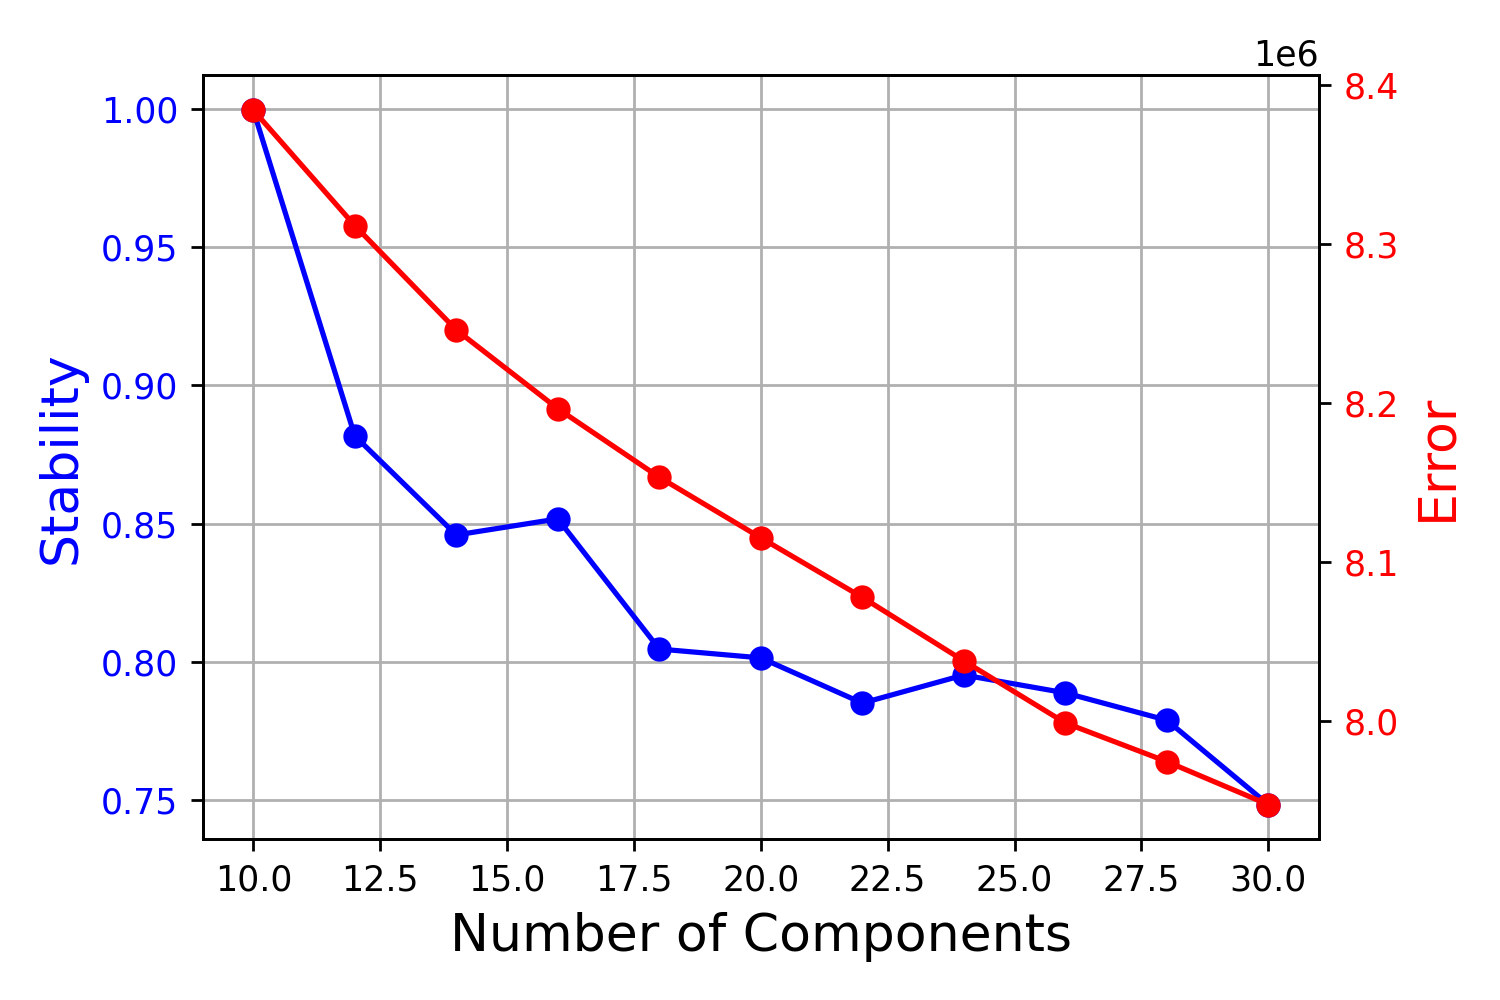

In [9]:
Image(filename = "tmp/step2/%s/%s.k_selection.png" %(run_name, run_name), width=1000, height=1000)

## 2.5 确定components的数量

In [24]:
selected_K = 16
density_threshold = 2.00

In [25]:
consensus_cmd = 'python %s/cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (
    cNMF_dir, output_dir, run_name, density_threshold, selected_K)
print('Consensus command for K=%s:\n%s' % (selected_K, consensus_cmd))
!{consensus_cmd}

Consensus command for K=16:
python ../cNMF/cnmf.py consensus --output-dir tmp/step2 --name 20210110 --local-density-threshold 2.00 --components 16 --show-clustering
/home/biostacs/anaconda2/envs/cnmf_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## 2.6 过滤program outliers

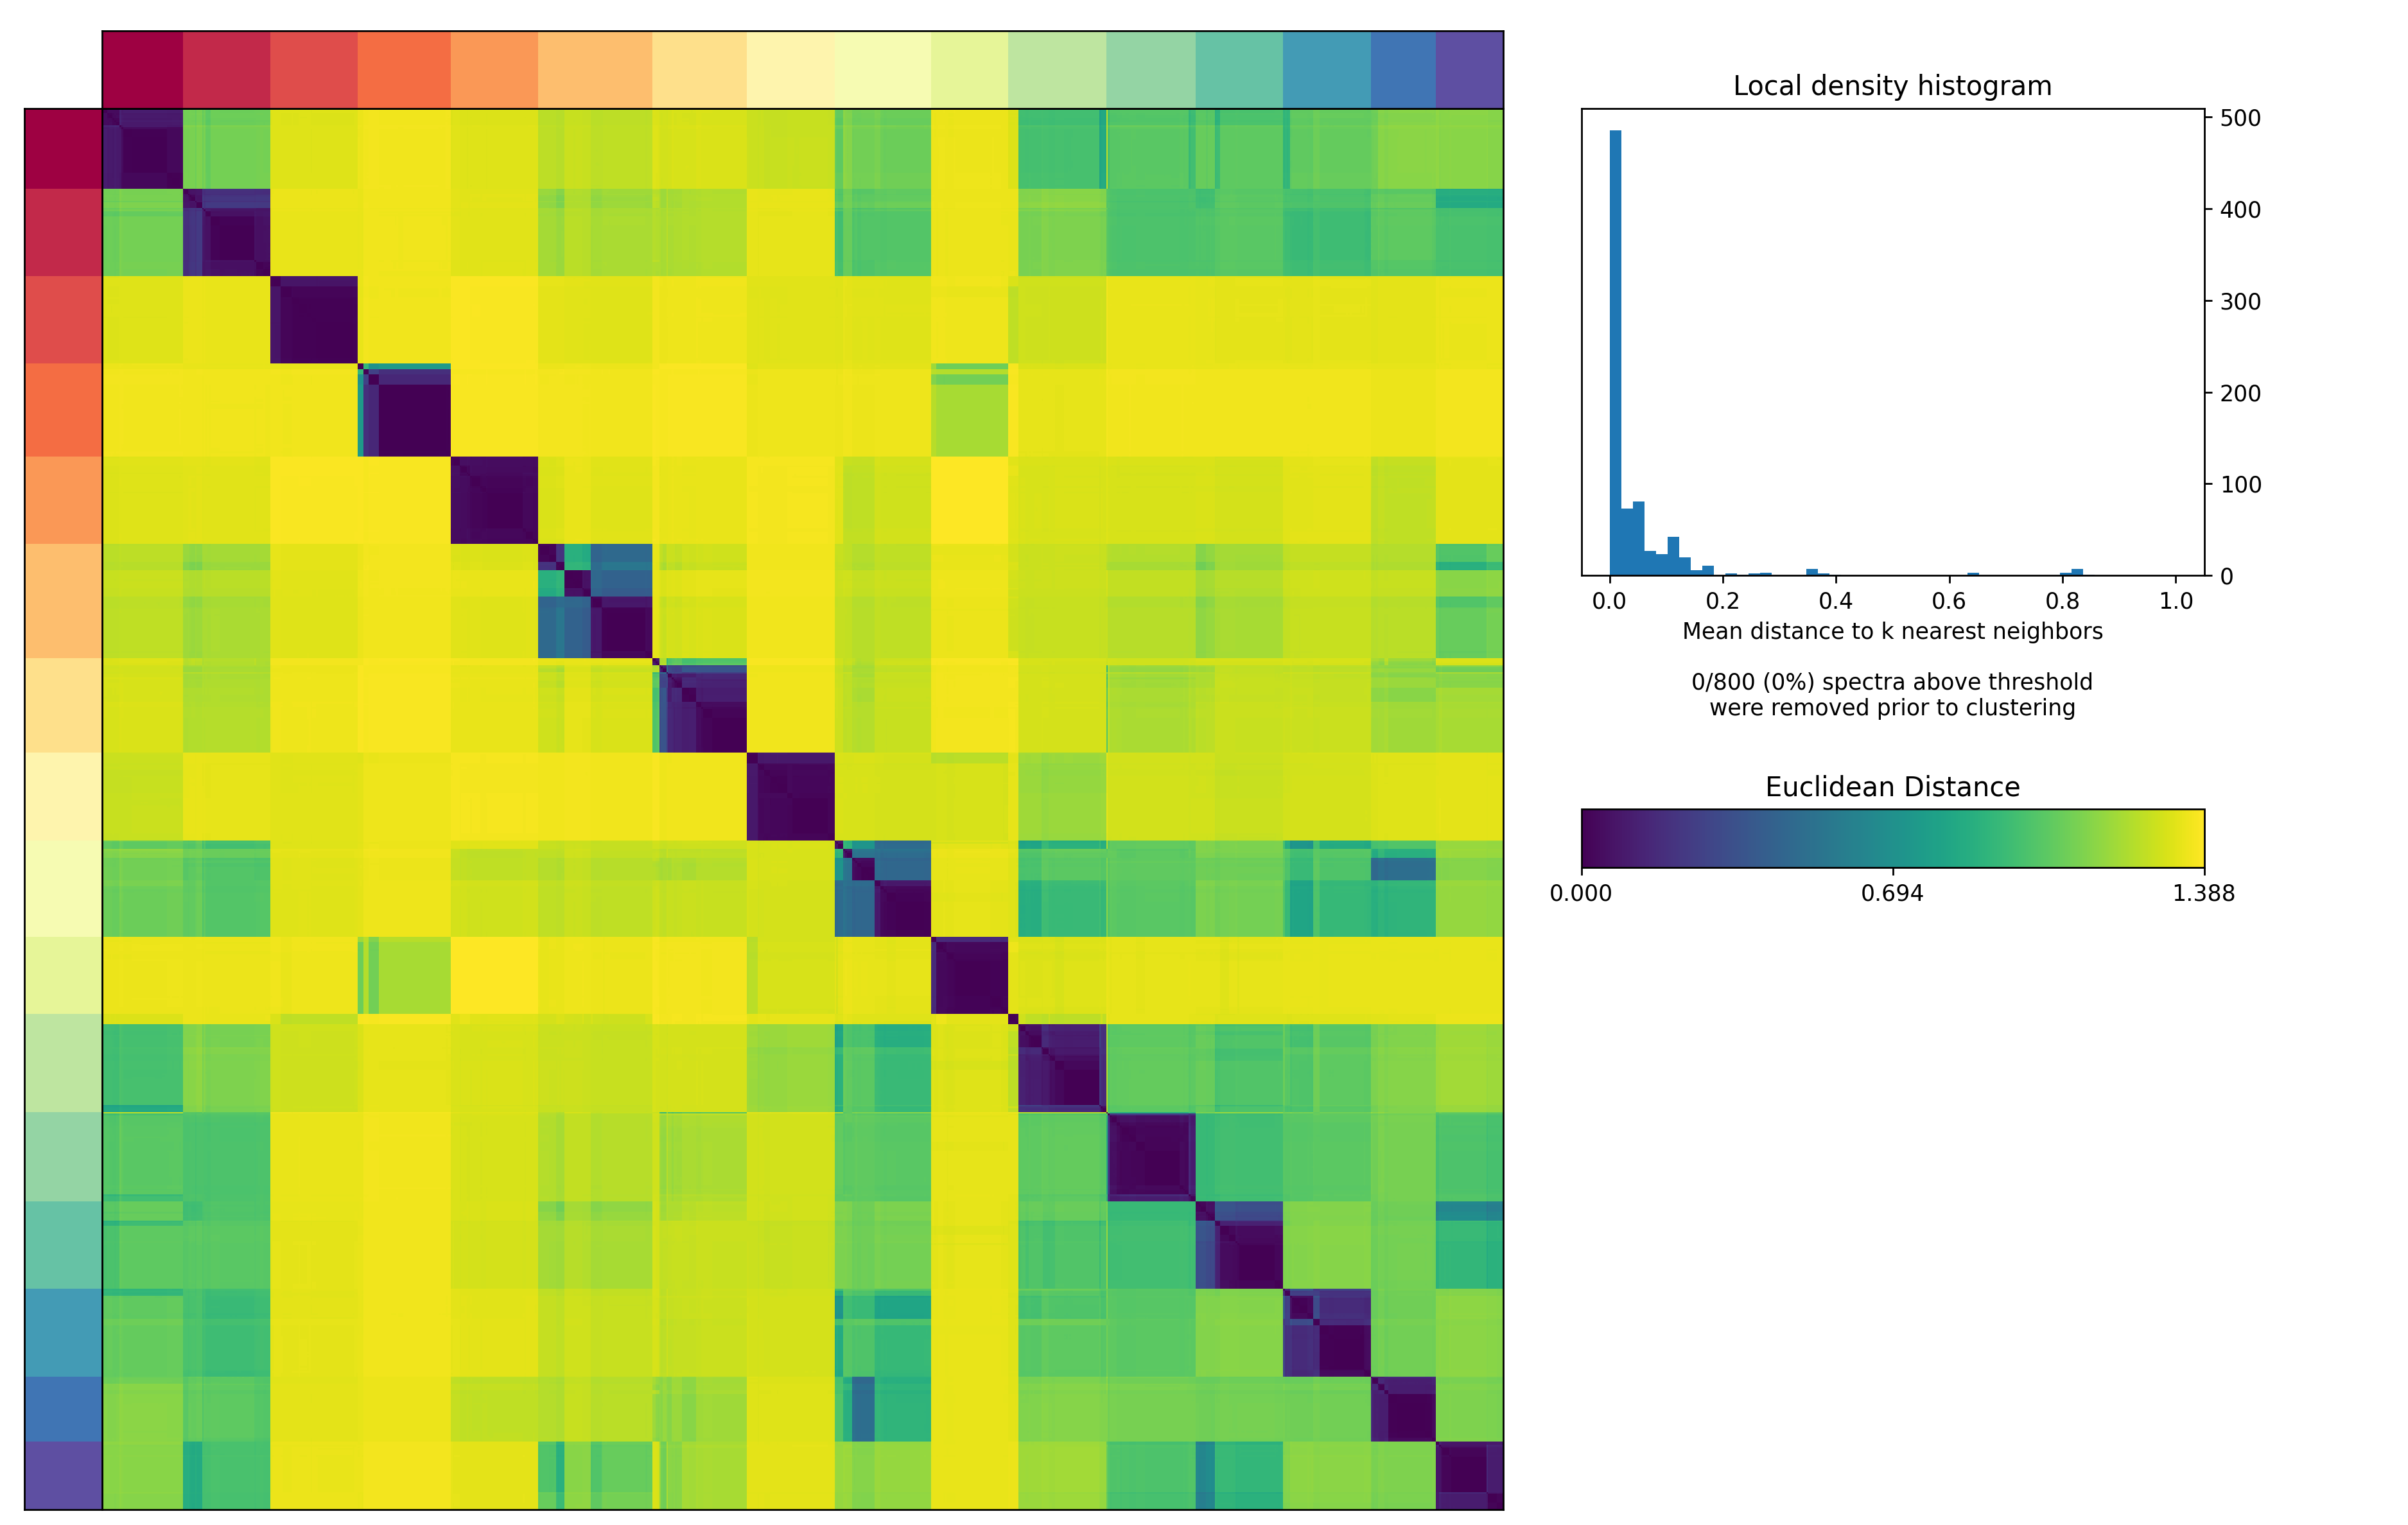

In [26]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
Image(filename = "tmp/step2/%s/%s.clustering.k_%d.dt_%s.png" % (run_name, run_name, selected_K, density_threshold_str),
      width=1000, height=1000)

In [27]:
density_threshold = 0.20

consensus_cmd = 'python %s/cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (
    cNMF_dir, output_dir, run_name, density_threshold, selected_K)
print('Consensus command for K=%s:\n%s' % (selected_K, consensus_cmd))
!{consensus_cmd}

Consensus command for K=16:
python ../cNMF/cnmf.py consensus --output-dir tmp/step2 --name 20210110 --local-density-threshold 0.20 --components 16 --show-clustering
/home/biostacs/anaconda2/envs/cnmf_env/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


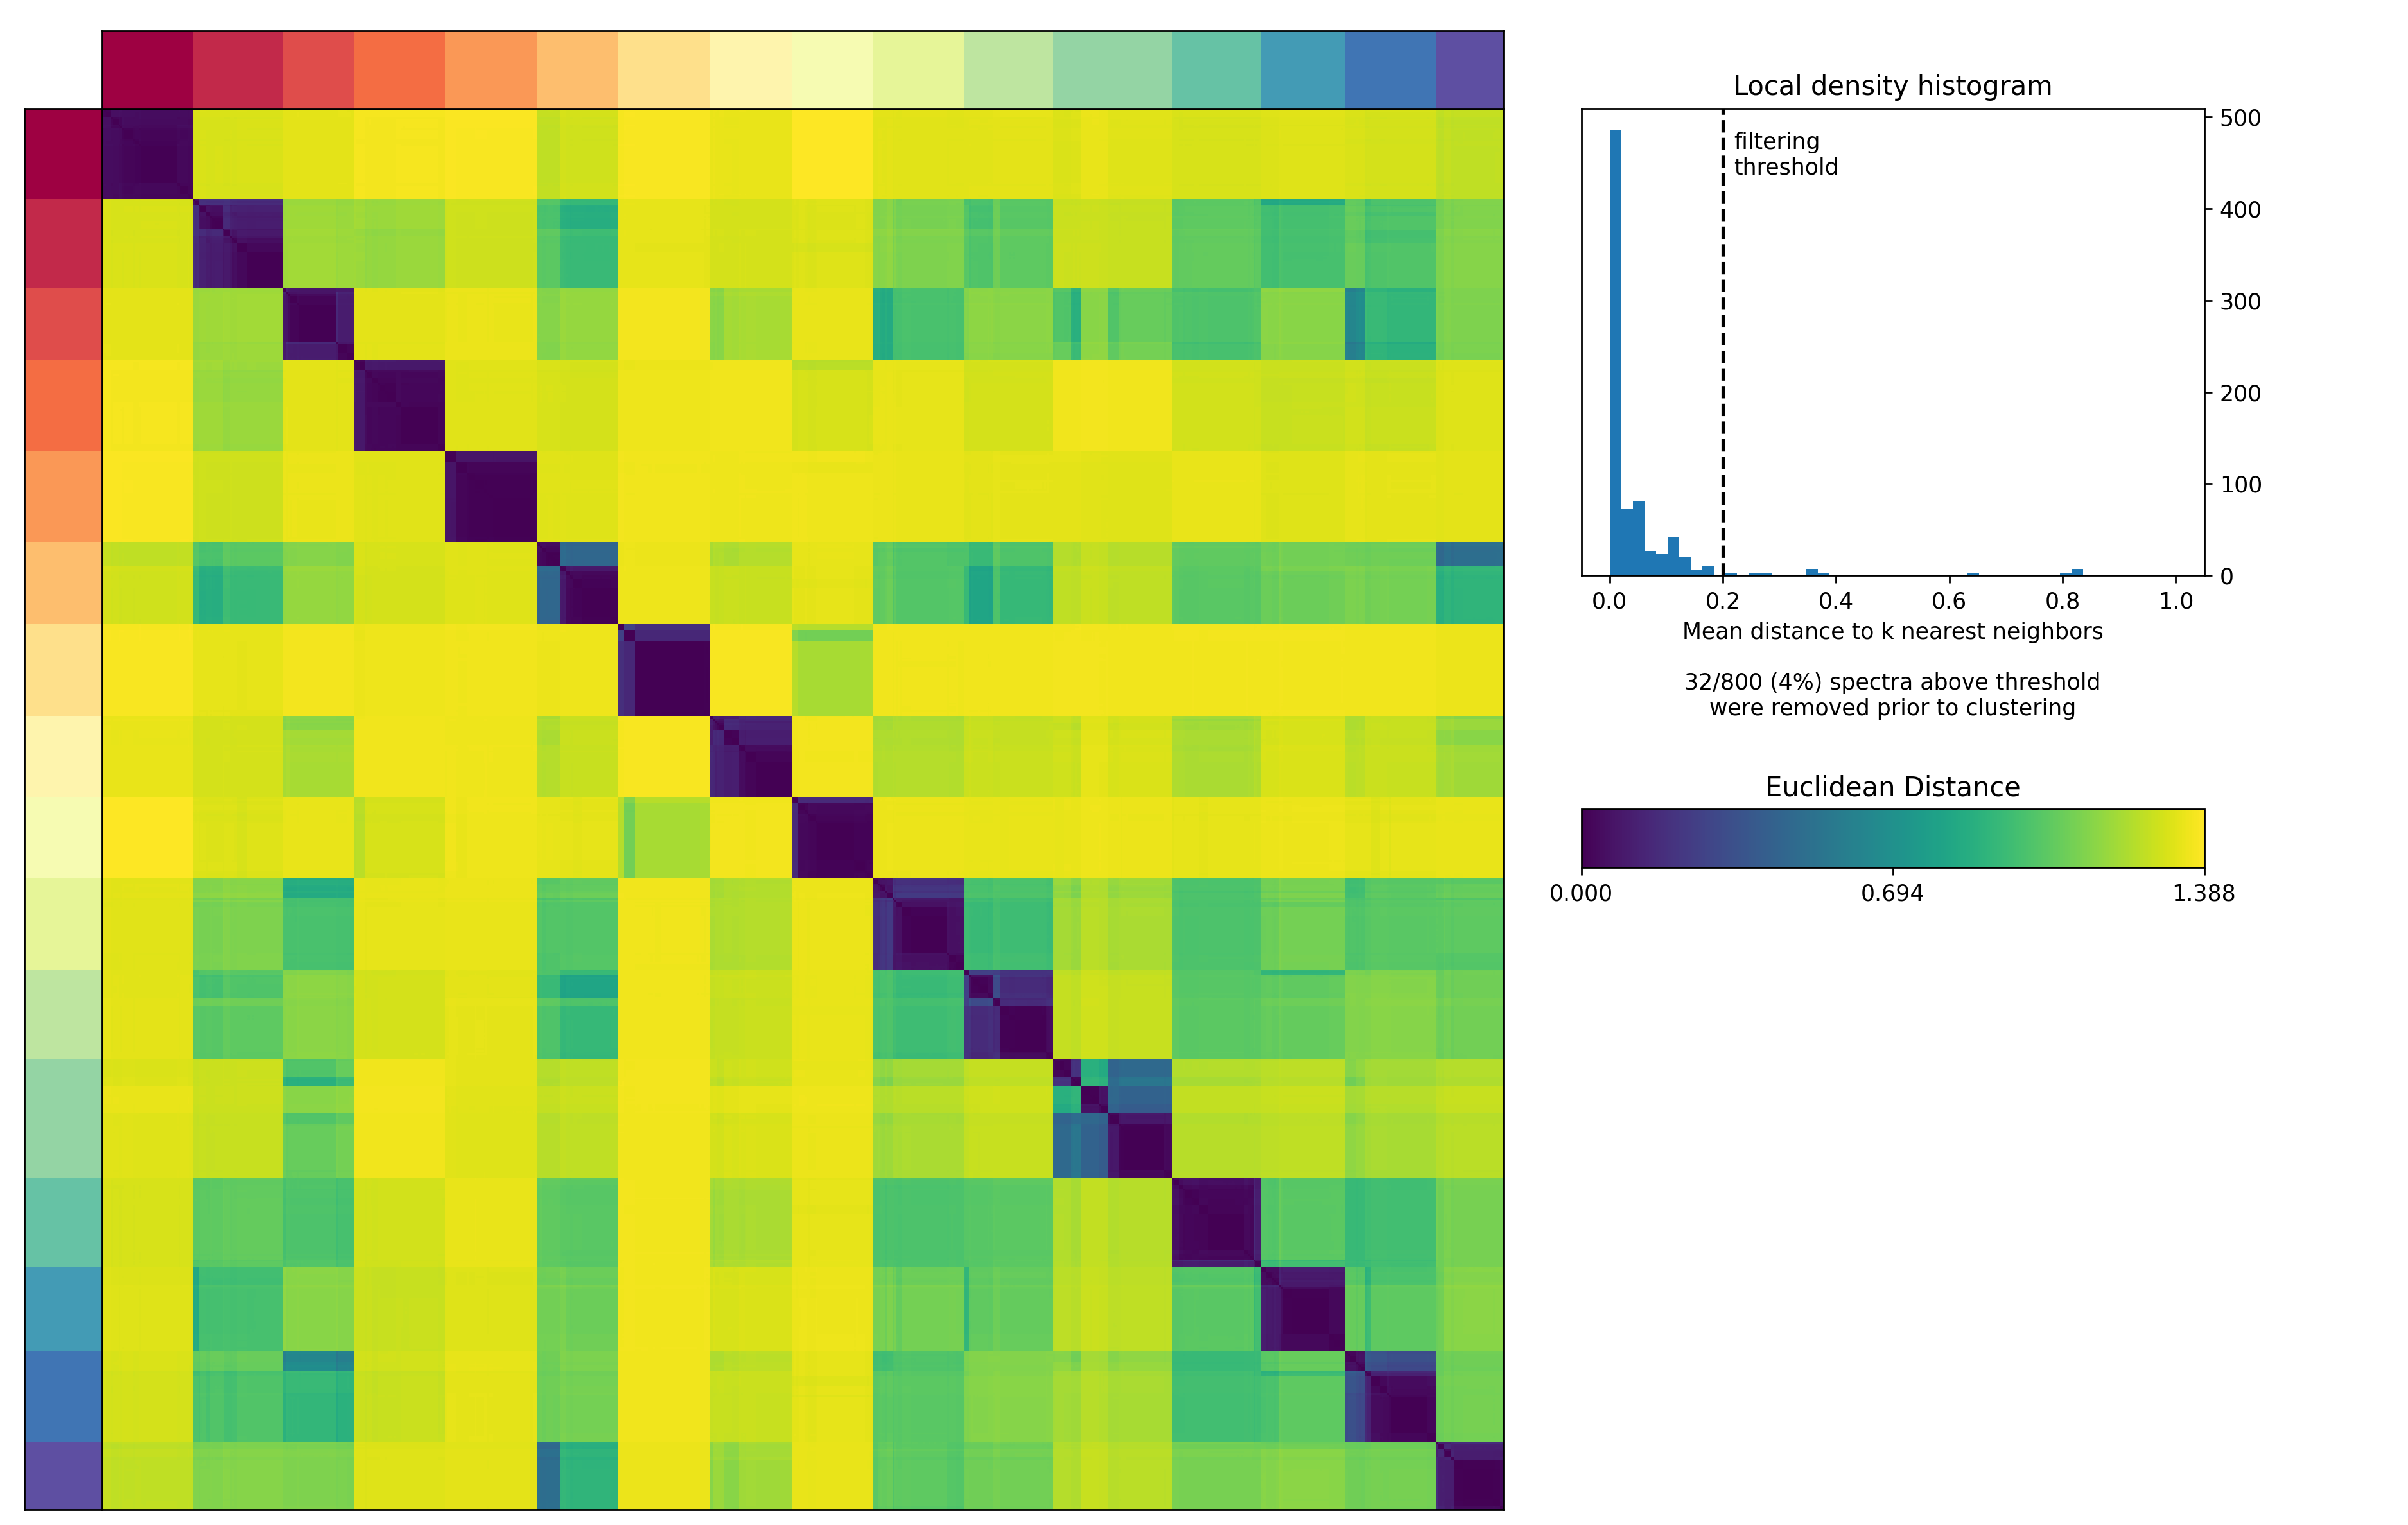

In [28]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
Image(filename = "tmp/step2/%s/%s.clustering.k_%d.dt_%s.png" % (run_name, run_name, selected_K, density_threshold_str),
      width=1000, height=1000)

## 3. Downstream analysis after cNMF
### 3.1 Normalize usage matrix

In [29]:
selected_K = 16
density_threshold = 0.20
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')

In [30]:
usage = pd.read_csv("tmp/step2/%s/%s.usages.k_%s.dt_%s.consensus.txt" % (run_name, run_name, selected_K, density_threshold_str), sep='\t', index_col=0)
usage.columns = ["Usage_%s" % i for i in usage.columns]
usage.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8,Usage_9,Usage_10,Usage_11,Usage_12,Usage_13,Usage_14,Usage_15,Usage_16
index,,,,,,,,,,,,,,,,
KP_30w_ND_m3_T7_P1_S302,0.0,7.937053,18.707338,0.000000,0.000000,2.922462,0.000000,0.000000,0.000000,0.000000,0.000000,915.438907,0.000000,0.000000,82.070586,11.559526
KP_30w_ND_m2_T4_P5_S331,0.0,0.000000,52.280391,0.000000,0.000000,0.000000,0.000000,131.926114,0.000000,0.000000,391.460413,0.000000,132.250614,0.000000,44.191479,0.000000
K_12w_ND_m3_T0_P2_S272,0.0,157.389868,0.000000,78.197363,0.000000,0.000000,4.749414,32.360056,10.846235,0.000000,15.100518,0.000000,34.782141,5.322041,233.399229,0.000000
KP_30w_ND_m2_T1_P4_S219,0.0,26.322103,0.000000,2.217085,0.000000,288.341425,0.000000,0.000000,0.000000,197.365916,64.292389,0.000000,41.929025,9.252015,64.748349,0.000000
K_2w_ND_m3_T0_P1_S245,0.0,48.577522,4.068943,165.298945,1107.526281,0.000000,10.476139,4.562794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,104.548089,42.225260


In [31]:
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8,Usage_9,Usage_10,Usage_11,Usage_12,Usage_13,Usage_14,Usage_15,Usage_16
index,,,,,,,,,,,,,,,,
KP_30w_ND_m3_T7_P1_S302,0.0,0.007642,0.018011,0.000000,0.000000,0.002814,0.000000,0.000000,0.000000,0.000000,0.000000,0.881386,0.000000,0.000000,0.079018,0.011130
KP_30w_ND_m2_T4_P5_S331,0.0,0.000000,0.069512,0.000000,0.000000,0.000000,0.000000,0.175408,0.000000,0.000000,0.520484,0.000000,0.175840,0.000000,0.058757,0.000000
K_12w_ND_m3_T0_P2_S272,0.0,0.275086,0.000000,0.136674,0.000000,0.000000,0.008301,0.056559,0.018957,0.000000,0.026393,0.000000,0.060792,0.009302,0.407936,0.000000
KP_30w_ND_m2_T1_P4_S219,0.0,0.037903,0.000000,0.003192,0.000000,0.415197,0.000000,0.000000,0.000000,0.284197,0.092578,0.000000,0.060376,0.013322,0.093234,0.000000
K_2w_ND_m3_T0_P1_S245,0.0,0.032662,0.002736,0.111141,0.744664,0.000000,0.007044,0.003068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070295,0.028391


In [32]:
usage_norm.to_csv("tmp/step2/%s/%s.usages.k_%s.dt_%s.consensus.normalized.txt" % (run_name, run_name, selected_K, density_threshold_str), sep="\t")

### 3.2 Extract genes with high loadings in each GEP (top100)

In [33]:
gene_scores = pd.read_csv("tmp/step2/%s/%s.gene_spectra_score.k_%s.dt_%s.txt" % (run_name, run_name, selected_K, density_threshold_str), sep="\t", index_col=0).T
gene_scores.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Gnai3,0.000141,-0.001302,0.000673,-0.000002,0.000352,-0.000913,-0.000057,0.000034,-0.000131,0.000819,0.000839,0.000447,0.000691,-0.000504,0.001014,0.000960
Cdc45,0.005450,-0.000809,0.000204,0.000042,-0.000218,0.000036,0.000087,-0.000734,-0.000073,-0.000223,-0.000389,0.000742,-0.000299,-0.000261,-0.000399,0.000951
H19,0.000259,-0.000258,-0.000550,-0.000079,0.000090,-0.000235,-0.000077,0.000216,-0.000098,-0.000081,-0.000058,0.003292,-0.000127,-0.000063,-0.000089,0.000155
Apoh,-0.000215,-0.000810,-0.000441,-0.000029,-0.000156,0.001127,-0.000090,0.000404,-0.000235,-0.000229,-0.000186,-0.000179,-0.000813,-0.000814,-0.000526,0.003310
Narf,-0.000241,-0.000802,0.000566,-0.000132,-0.000226,-0.000268,0.000155,0.000361,0.000347,0.000652,-0.000147,0.000312,0.000561,0.000286,-0.000293,0.001126


In [34]:
## Obtain the top 300 genes for each GEP in sorted order and combine them into a single dataframe

top_genes = []
ngenes = 100
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes.columns = ["program_%s" % i for i in top_genes.columns]
top_genes.head()

,program_1,program_2,program_3,program_4,program_5,program_6,program_7,program_8,program_9,program_10,program_11,program_12,program_13,program_14,program_15,program_16
0,Birc5,Cbr2,Aldh1a3,Gbp10,Fendrr,Scgb3a2,Itk,Ush1c,Cyp4f18,Pnp2,Azgp1,Stmn2,Alpi,Akap5,Lhfp,Vcan
1,Pbk,Acoxl,Trdv4,Iigp1,Cdh5,Bpifa1,Cd3g,Lypd8,Iglc2,Fxyd2,Ly6k,Sdc3,Hbb-bs,Rtkn2,Gdf15,Dcpp1
2,Pclaf,Gm11771,Cwh43,F830016B08Rik,Clec1a,Pf4,Cd3d,Anxa13,Sirpb1b,Tfap2b,Lrrc52,Ifi204,Lrrc26,Col4a3,Fosl1,Dcpp2
3,Ccna2,Hc,Nrk,Gm43302,Tie1,Gdpd2,Nsg2,Cdhr5,Cd19,Igfbp3,Lrmp,Fam19a5,Hba-a2,Sema3a,Asns,Habp2
4,Nusap1,Chia1,Tmprss11e,Tgtp2,Clec14a,Bpifb2,Rag1,Pla2g10,Il1b,Lman1l,BC018473,Ifi211,Gldc,Col4a4,Gm42899,Apoa1


In [35]:
gene_scores.columns = ["program_%s" % i for i in gene_scores.columns]
gene_scores.head()

,program_1,program_2,program_3,program_4,program_5,program_6,program_7,program_8,program_9,program_10,program_11,program_12,program_13,program_14,program_15,program_16
Gnai3,0.000141,-0.001302,0.000673,-0.000002,0.000352,-0.000913,-0.000057,0.000034,-0.000131,0.000819,0.000839,0.000447,0.000691,-0.000504,0.001014,0.000960
Cdc45,0.005450,-0.000809,0.000204,0.000042,-0.000218,0.000036,0.000087,-0.000734,-0.000073,-0.000223,-0.000389,0.000742,-0.000299,-0.000261,-0.000399,0.000951
H19,0.000259,-0.000258,-0.000550,-0.000079,0.000090,-0.000235,-0.000077,0.000216,-0.000098,-0.000081,-0.000058,0.003292,-0.000127,-0.000063,-0.000089,0.000155
Apoh,-0.000215,-0.000810,-0.000441,-0.000029,-0.000156,0.001127,-0.000090,0.000404,-0.000235,-0.000229,-0.000186,-0.000179,-0.000813,-0.000814,-0.000526,0.003310
Narf,-0.000241,-0.000802,0.000566,-0.000132,-0.000226,-0.000268,0.000155,0.000361,0.000347,0.000652,-0.000147,0.000312,0.000561,0.000286,-0.000293,0.001126


In [36]:
top_genes.to_csv("tmp/step2/%s/%s.top%s_genes.k_%s.dt_%s.txt" % (run_name, run_name, ngenes, selected_K, density_threshold_str), sep="\t", index=0)
gene_scores.to_csv("tmp/step2/%s/%s.gene_spectra_score.k_%s.dt_%s.T.txt" % (run_name, run_name, selected_K, density_threshold_str), sep="\t", index=1)